<a href="https://colab.research.google.com/github/keerthana-narra/Stock-Prediction/blob/main/N_Sai_Keerthana_reddy_Nifty_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem Statement : We have the data of Nifty50 stock from 2000 to till date. The data has four features of high, low, open and close. This can be suited by time series model. The task here is to predict what would be the closing stock price.



##Loading data and importing libraries

In [1]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 8.2MB/s 
     |████████████████████████████████| 9.5MB 37.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [55]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                   # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

In [8]:
missing_values = ['N/a', 'na', 'np-nan']

In [131]:
#Reading data
nifty = pd.read_csv("/content/drive/MyDrive/Almabetter/Cohort Nilgiri/capstone-2/ Nifty50_data.csv", na_values= missing_values, header=0, index_col=0, parse_dates=True, squeeze=True)

In [6]:
nifty.head()

,Open,High,Low,Close
Date,,,,
2000-01-03,1482.15,1592.90,1482.15,1592.2
2000-01-04,1594.40,1641.95,1594.40,1638.7
2000-01-05,1634.55,1635.50,1555.05,1595.8
2000-01-06,1595.80,1639.00,1595.80,1617.6
2000-01-07,1616.60,1628.25,1597.20,1613.3


## Understanding data and Cleaning data




In [11]:
#Shape of dataset
nifty.shape

(5301, 4)

In [12]:
#Acessing top 5 rows
nifty.head()

,Open,High,Low,Close
Date,,,,
2000-01-03,1482.15,1592.90,1482.15,1592.2
2000-01-04,1594.40,1641.95,1594.40,1638.7
2000-01-05,1634.55,1635.50,1555.05,1595.8
2000-01-06,1595.80,1639.00,1595.80,1617.6
2000-01-07,1616.60,1628.25,1597.20,1613.3


In [13]:
# Acessing bottom 5 rows
nifty.tail()

,Open,High,Low,Close
Date,,,,
2021-05-04,14687.250000,14723.400391,14461.500000,14496.500000
2021-05-05,14604.150391,14637.900391,14506.599609,14617.849609
2021-05-06,14668.349609,14743.900391,14611.500000,14724.799805
2021-05-07,14816.849609,14863.049805,14765.500000,14823.150391
2021-05-10,14928.250000,14966.900391,14892.500000,14942.349609


The data is a daily recorded data. It has data from 01 January 2000 to 10 May 2021.

In [14]:
# Checking for null values
nifty.isnull().sum()

Open     35
High     35
Low      35
Close    35
dtype: int64

The data has null values. So it will require any null treatment.

In [132]:
nifty = nifty.interpolate()


To treat null vaules here I used interpolate method. In which the null value is filled by the average of above and below values.

In [16]:
# Describing data
nifty.describe()

,Open,High,Low,Close
count,5301.000000,5301.000000,5301.000000,5301.000000
mean,5559.311660,5596.408330,5514.357326,5556.140654
std,3578.384109,3590.088394,3556.946877,3573.791012
min,853.000000,877.000000,849.950000,854.200000
25%,2063.600000,2081.850000,2051.350000,2063.400000
50%,5215.899902,5255.649902,5169.049805,5215.700195
75%,8262.549805,8308.150391,8216.400391,8262.349609
max,15371.450195,15431.750000,15243.400391,15314.700195


In [17]:
# Checking index
nifty.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
               '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
               '2021-05-07', '2021-05-10'],
              dtype='datetime64[ns]', name='Date', length=5301, freq=None)

In [18]:
# Create the dependent variable..we want to predict the directionality of index movement in next day.
nifty.loc[(nifty['Close']-nifty['Close'].shift(-3)) < 0,'target']=1  # If the index goes up in the next day it is taken as 1
nifty.loc[(nifty['Close']-nifty['Close'].shift(-3)) > 0,'target']=0  # If the index goes down in the next day it is taken as 0

In [21]:
# Obtaining the class distribution of both classes of our dependent variable
nifty.target.value_counts()

1.0    2941
0.0    2356
Name: target, dtype: int64

In [22]:
nifty.info

<bound method DataFrame.info of                     Open          High           Low         Close  target
Date                                                                      
2000-01-03   1482.150000   1592.900000   1482.150000   1592.200000     1.0
2000-01-04   1594.400000   1641.950000   1594.400000   1638.700000     0.0
2000-01-05   1634.550000   1635.500000   1555.050000   1595.800000     1.0
2000-01-06   1595.800000   1639.000000   1595.800000   1617.600000     0.0
2000-01-07   1616.600000   1628.250000   1597.200000   1613.300000     1.0
...                  ...           ...           ...           ...     ...
2021-05-04  14687.250000  14723.400391  14461.500000  14496.500000     1.0
2021-05-05  14604.150391  14637.900391  14506.599609  14617.849609     1.0
2021-05-06  14668.349609  14743.900391  14611.500000  14724.799805     NaN
2021-05-07  14816.849609  14863.049805  14765.500000  14823.150391     NaN
2021-05-10  14928.250000  14966.900391  14892.500000  14942.349609  

##Visualizations

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



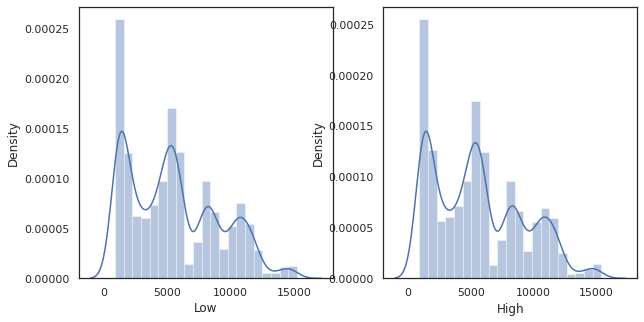

In [24]:
# Dist plots
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.distplot(nifty['Low'], ax=axes[0])
sns.distplot(nifty['High'], ax=axes[1])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



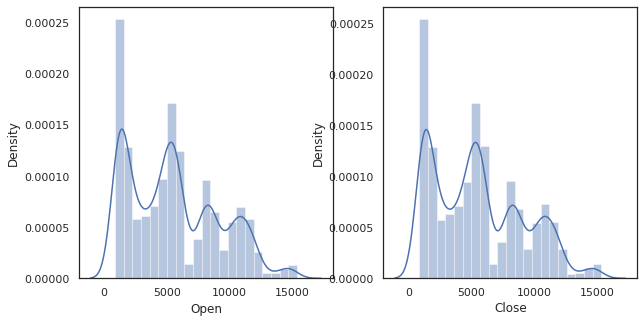

In [25]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.distplot(nifty['Open'], ax=axes[0])
sns.distplot(nifty['Close'], ax=axes[1])


The data is distributed over a range. It can observed that there is more density of observations at low prices. And there is trend of decreasing. 
This can mean in two ways. First one is nifty is likely to have low values in the range 1000-7000 or the second way is that the no.of observations recorded at higher prices are comparitively low. 

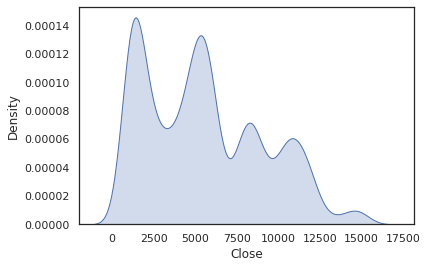

In [26]:
sns.kdeplot(nifty['Close'],shade=True)


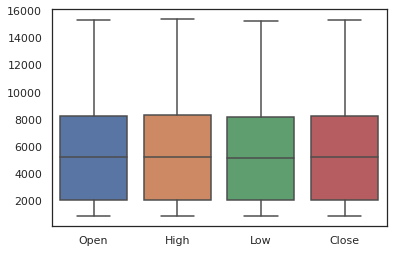

In [27]:
# box plot
sns.boxplot(data=nifty[['Open','High','Low','Close']])

From the above box plots we can infere that the data of the features of a taken are more or less similar. There are no outlier observations which needs to be appreciated.

let us see some Correlation plots

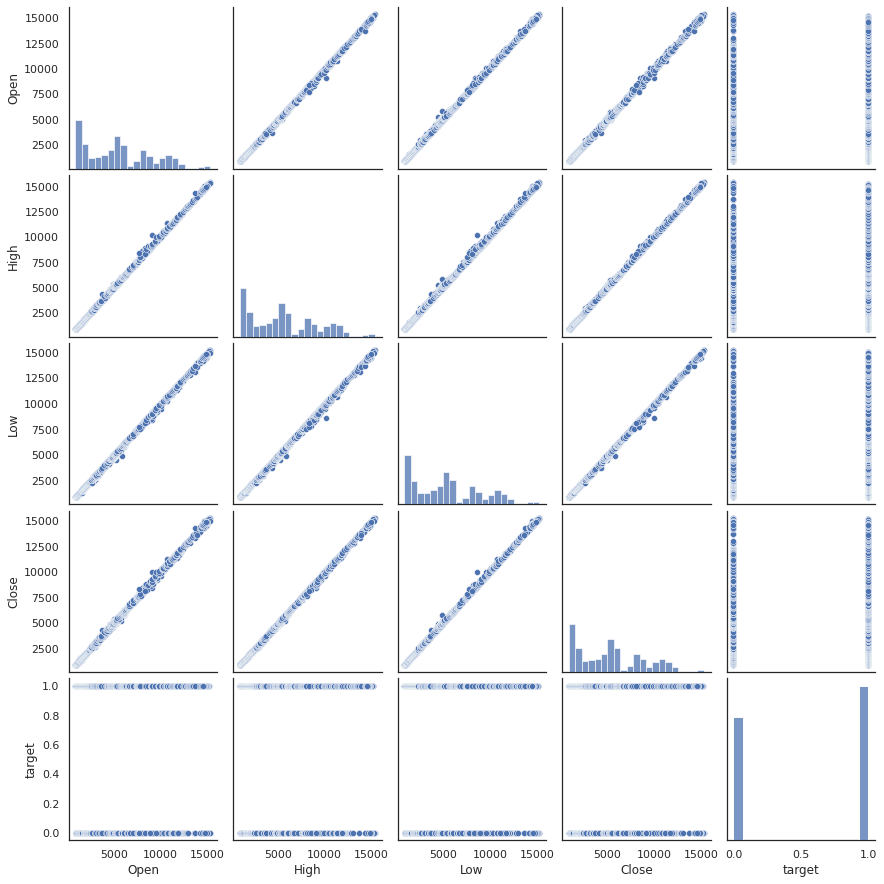

In [28]:
#pair plot
sns.pairplot(nifty[1:])

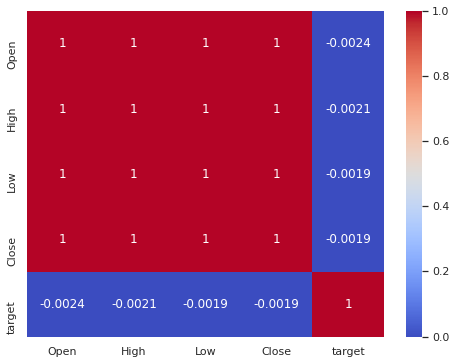

In [29]:
 ## Correlation heat map
plt.figure(figsize=(8,6))
correlation = nifty.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [38]:
# Storing columns of nifty dataset in a variable
features = nifty.describe().columns
print(features)

Index(['Open', 'High', 'Low', 'Close', 'target'], dtype='object')


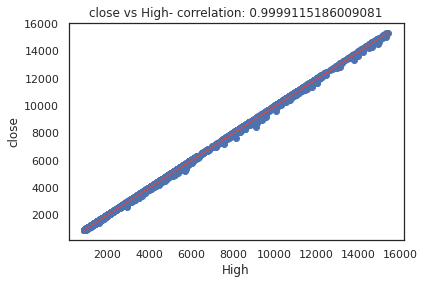

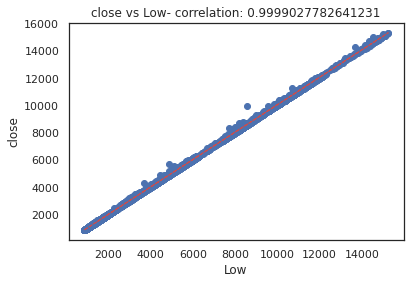

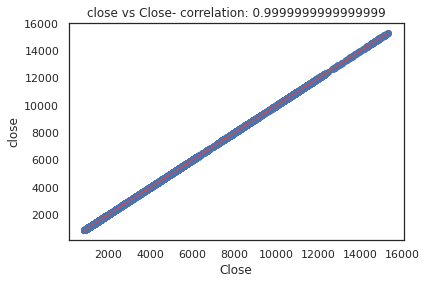

In [31]:
#Sactter plot with estimating correlation values
for col in features[1:-1]:
    fig = plt.figure(figsize=(6, 4))
    ax = fig.gca()
    feature = nifty[col]
    label = nifty['Close']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('close')
    ax.set_title('close vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(nifty[col], nifty['Close'], 1)
    y_hat = np.poly1d(z)(nifty[col])

    plt.plot(nifty[col], y_hat, "r--", lw=1)

plt.show()

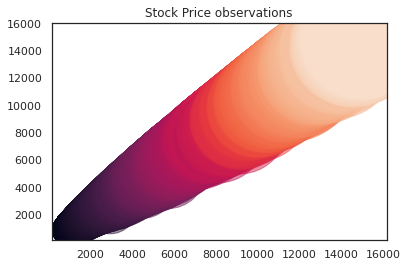

In [32]:
# Scatter plot
plt.scatter(nifty['High'], nifty['Close'], nifty['Open'], nifty['Low'], alpha=0.5)
plt.title('Stock Price observations')
plt.show()

The above pair plot and scatter plot shows that the features close, high, low, open are having strong positive correlation. This mean that stock price range observed in a particular month is in range of their own features.

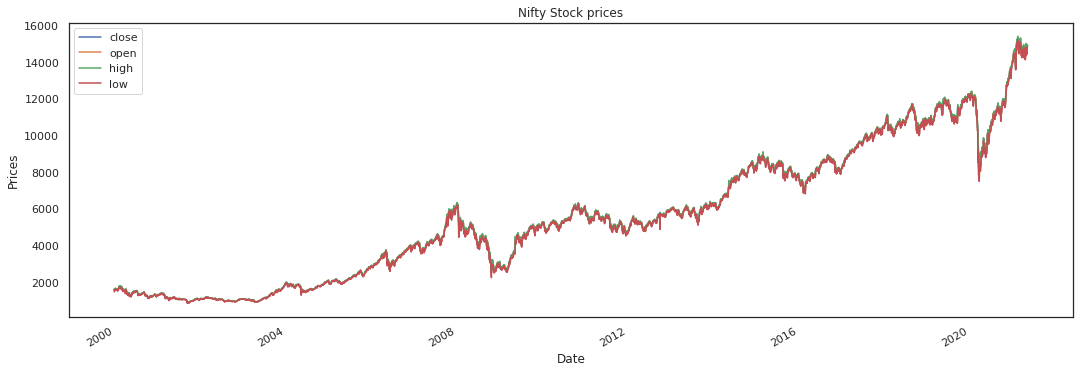

In [33]:
#Multi Line plot
plt.subplots(figsize=(18,6))
plt.xlabel('Date')
plt.ylabel('Prices')
nifty['Close'].plot(label='close')
nifty['Open'].plot(label='open')
nifty['High'].plot(label='high')
nifty['Low'].plot(label='low')
plt.legend()
plt.title('Nifty Stock prices')
plt.show()

The lag1 shows highly positive correlation which decreas

from here we can see there is increasing trend and thats the reason 

The features of the data are seeming to get overlapped

#### Understanding more about target variable

In [39]:
close = nifty['Close']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



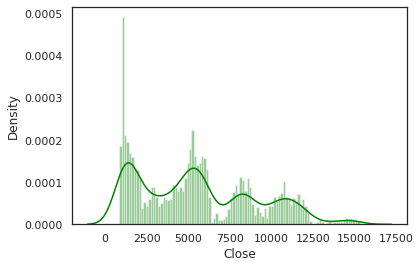

In [40]:
sns.distplot(nifty.loc['2000-01-01':'2021-05-01']['Close'],color='green',bins=100)


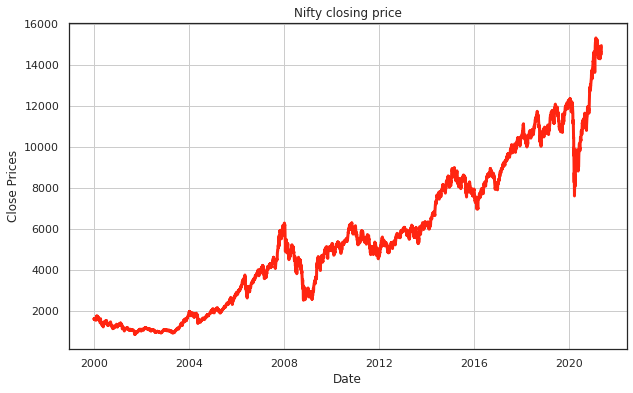

In [41]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot( close.index, close.values, marker='', color='#FF2511', linewidth=3)
plt.title('Nifty closing price')
plt.show()


there is a drastic drop can be seen in 2020 due to lockdown which was implemented in the country.

In [54]:
nifty[nifty['Close']== nifty['Close'].max()]


,Open,High,Low,Close,target
Date,,,,,
2021-02-15,15270.299805,15340.150391,15243.400391,15314.700195,0.0


In [43]:
nifty.iloc[2200:3400] # This shows that the maximum value occured is not a reason of outlier and the data is likely to see maximum points with time.

,Open,High,Low,Close,target
Date,,,,,
2008-10-14,3494.100098,3648.250000,3491.500000,3518.649902,0.0
2008-10-15,3517.899902,3518.500000,3324.550049,3338.399902,0.0
2008-10-16,3333.850098,3333.850098,3099.899902,3269.300049,0.0
2008-10-17,3269.050049,3335.949951,3046.600098,3074.350098,0.0
2008-10-20,3108.199951,3238.399902,3058.949951,3122.800049,0.0
...,...,...,...,...,...
2013-08-13,5600.250000,5704.750000,5578.899902,5699.299805,0.0
2013-08-14,5715.399902,5754.549805,5690.200195,5742.299805,0.0
2013-08-16,5705.450195,5716.600098,5496.049805,5507.850098,0.0


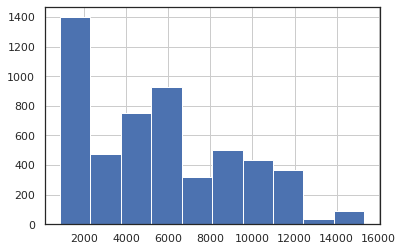

In [44]:
close.hist()

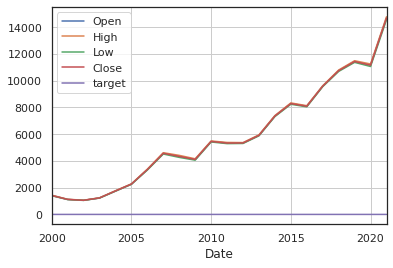

In [45]:
# Time resampling with rule AS - Year start
x = nifty.resample(rule = 'AS').mean()
x.plot()
plt.grid('true')

Despite of the high and low prices recorded open and close prices kind of overlap or likely to be near values.

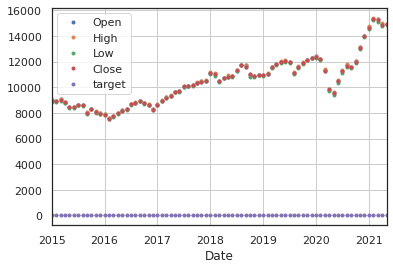

In [46]:
# Time resampling with rule M - Month end
x = nifty.resample(rule = 'M').max()
x.plot(xlim = ["2015-01-01", "2021-05-10"], style = '.')
plt.grid('true')

Lag Scatter plots : Relation between a observation and its previous observation.
Previous observations are termed as lags. Lag at one step is lag1 and two steps is lag2. Lag_plot plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



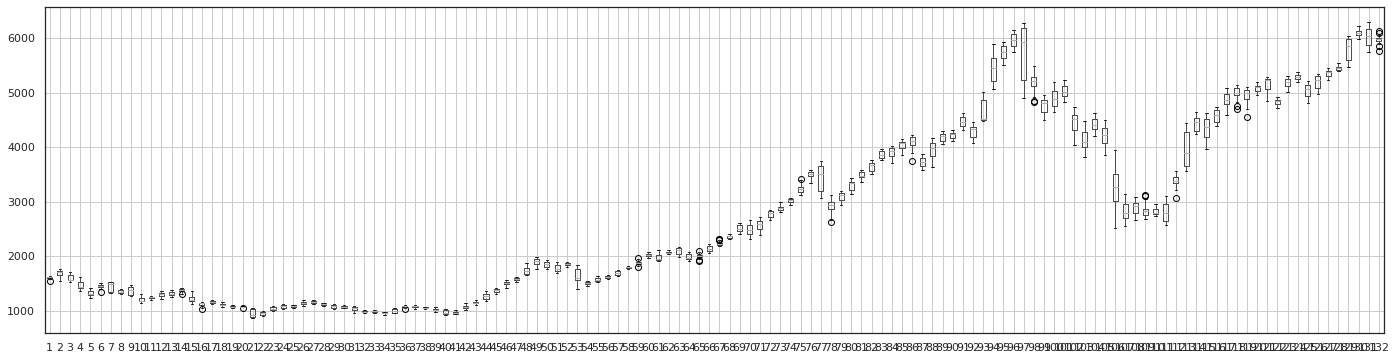

In [47]:
# Box plot
from pandas import Grouper
from pandas import DataFrame
from pandas import concat
plt.figure(figsize=(24,6))

first_ten_years = close['2000':'2010']
groups = first_ten_years.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,133)
months.boxplot()
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



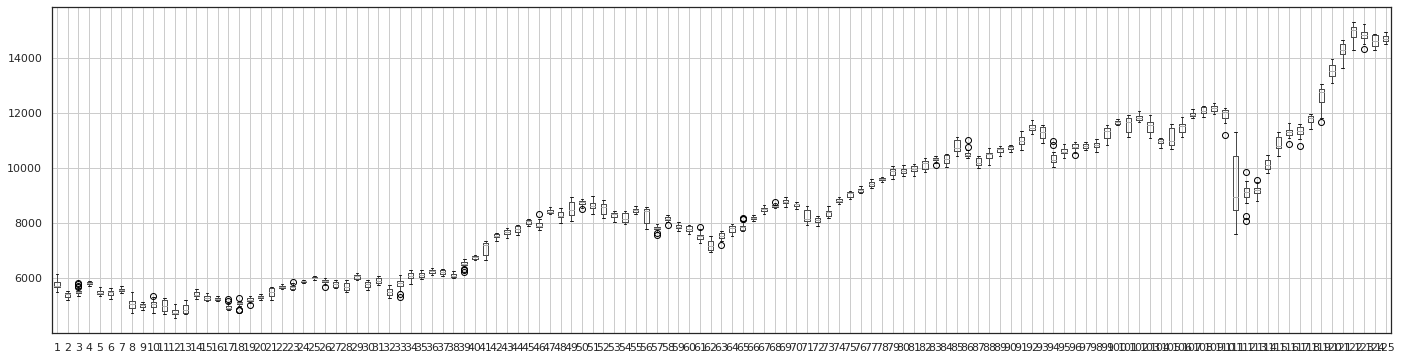

In [48]:

plt.figure(figsize=(24,6))

next_ten_years = close['2011':'2021']
groups = next_ten_years.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,126)
months.boxplot()
plt.show()

These box plots show the distribution of monthly data. For visibility purpose the data was divided into 2 and plotted.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


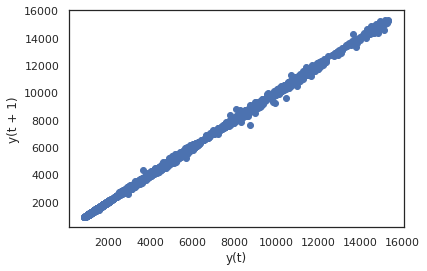

In [49]:
# Lag plot
from pandas.plotting import lag_plot
lag_plot(close)
plt.show()

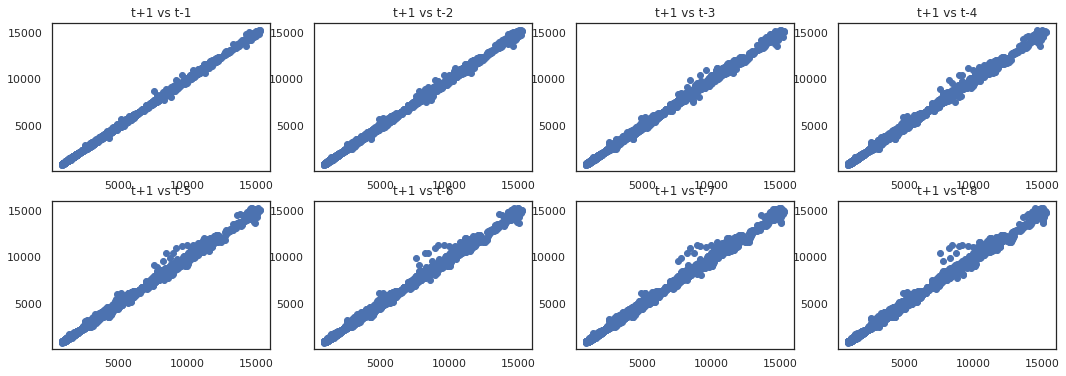

In [50]:
from pandas import DataFrame
from pandas import concat
values = DataFrame(close.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.subplots(figsize=(18,6))
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
plt.show()


Lag plots show that when we want to predict for next day it gets mostly correct prediction and using the same if we want to predict after a week the predict may vary . How ever in this case its showing positive correlation even for a plot after a week. 

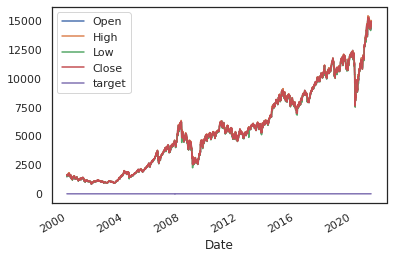

In [52]:
nifty.plot()

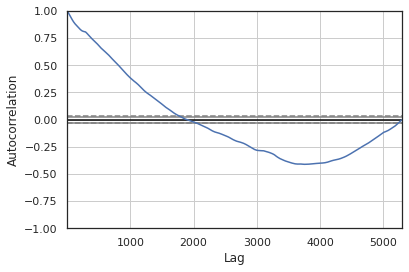

In [63]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nifty['Close'])
plt.show()

## Checking Stationarity

In [56]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [57]:
#Function for performing dicky fuller test
def dicky_fuller_test(x):
  
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")


In [58]:
# function to plot auto correlation and partial auto correlation plots
def cor_plots(x):
  fig = plt.figure(figsize=(12,8))
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf(nifty[x].dropna(),lags=12,ax=ax1)
  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf(nifty[x].dropna(),lags=12,ax=ax2)


A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.
And partial auto correlation recurssion effect occuring in auto correlation is removed.

In [64]:
# applying dicky fuller test on nifty['Close']
dicky_fuller_test(nifty['Close'])


ADF Statistic: 0.765711
p-value: 0.991062
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data is non-stationary


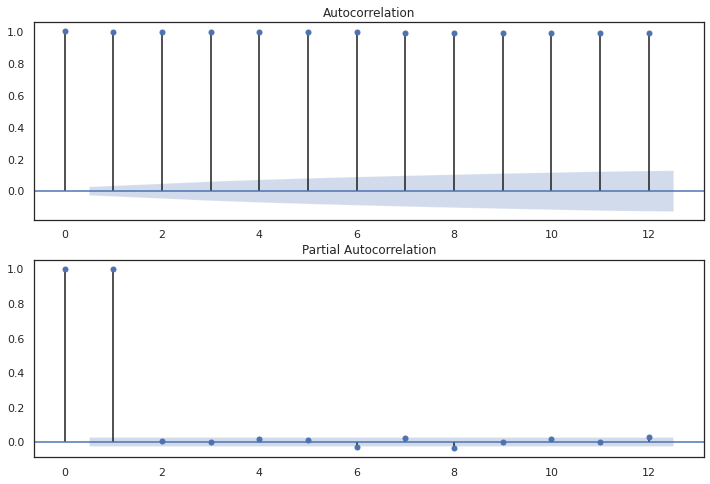

In [ ]:
cor_plots('Close') #Plots

In [60]:
nifty['Close_1'] = nifty['Close'] - nifty['Close'].shift(1) # Differencing 


In [61]:
dicky_fuller_test(nifty['Close_1'].dropna())

ADF Statistic: -19.884604
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data is stationary.


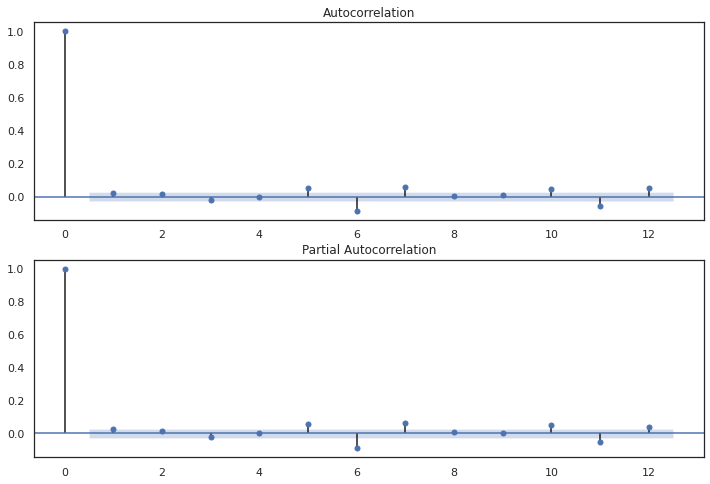

In [62]:
cor_plots('Close_1') #plots

In [91]:
# Close variable over time on differncing 
fig = go.Figure([go.Scatter(x=nifty.Date,y=nifty.Close_1)])
fig.update_layout(width=1000, height=500,
    title='Close variable over time on differencing ')
fig.show()


In [65]:
nifty.head()

,Open,High,Low,Close,target,Close_1
Date,,,,,,
2000-01-03,1482.15,1592.90,1482.15,1592.2,1.0,NaN
2000-01-04,1594.40,1641.95,1594.40,1638.7,0.0,46.5
2000-01-05,1634.55,1635.50,1555.05,1595.8,1.0,-42.9
2000-01-06,1595.80,1639.00,1595.80,1617.6,0.0,21.8
2000-01-07,1616.60,1628.25,1597.20,1613.3,1.0,-4.3


We can have two decomposition models

Additive:  = Trend + Seasonal + Random

Multiplicative:  = Trend * Seasonal * Random

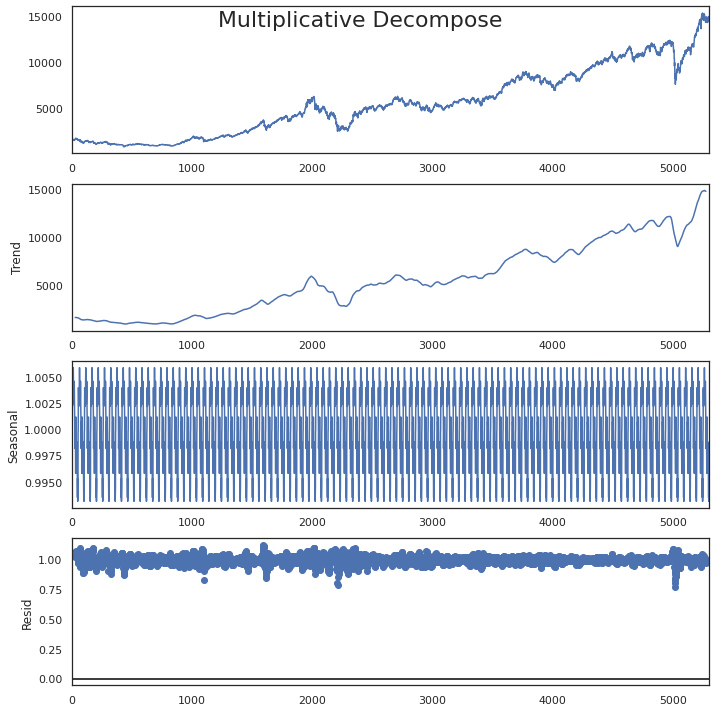

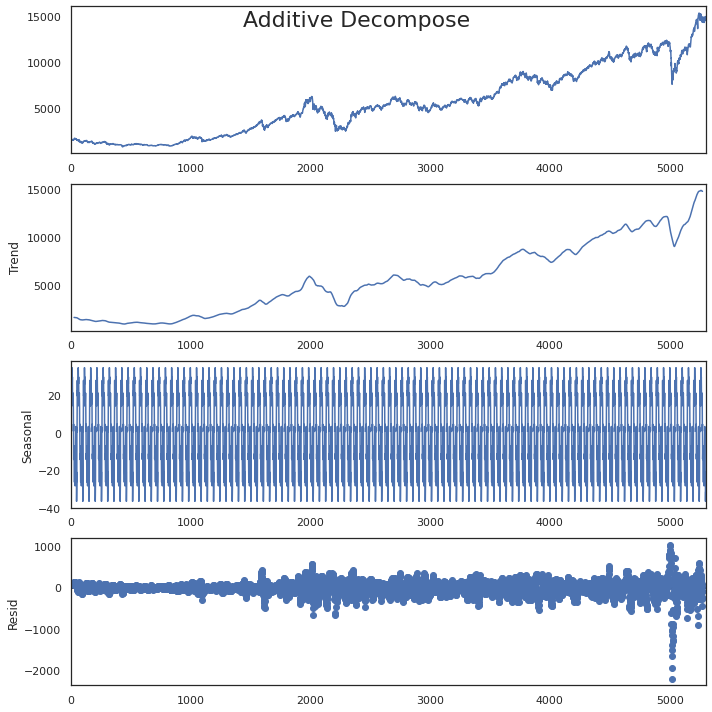

In [92]:
# Decompostion models
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})
y = nifty['Close'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


There is no much difference in both the decomposition models. 

## Feature Engineering

In [136]:
# Resetting nifty index
nifty = nifty.reset_index()

In [228]:
help(nifty[lag_features].rolling)

Help on method rolling in module pandas.core.generic:

rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None) method of pandas.core.frame.DataFrame instance
    Provide rolling window calculations.
    
    Parameters
    ----------
    window : int, offset, or BaseIndexer subclass
        Size of the moving window. This is the number of observations used for
        calculating the statistic. Each window will be a fixed size.
    
        If its an offset then this will be the time period of each window. Each
        window will be a variable sized based on the observations included in
        the time-period. This is only valid for datetimelike indexes.
    
        If a BaseIndexer subclass is passed, calculates the window boundaries
        based on the defined ``get_window_bounds`` method. Additional rolling
        keyword arguments, namely `min_periods`, `center`, and
        `closed` will be passed to `get_window_bounds`.
    min_periods : 

In [137]:
#Here rolling is used to extract features. 
lag_features = ["High", "Low", "Open", "Close"]
window1 = 1
window2 = 3
window3 = 7
window4 = 30

nifty_rolled_1d = nifty[lag_features].rolling(window=window1, min_periods=0)
nifty_rolled_3d = nifty[lag_features].rolling(window=window2, min_periods=0)
nifty_rolled_7d = nifty[lag_features].rolling(window=window3, min_periods=0)
nifty_rolled_30d = nifty[lag_features].rolling(window=window4, min_periods=0)

nifty_1d = nifty_rolled_1d.mean().shift(1).reset_index().astype(np.float32)
nifty_3d = nifty_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
nifty_7d = nifty_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
nifty_30d = nifty_rolled_30d.mean().shift(1).reset_index().astype(np.float32)


for feature in lag_features:
    nifty[f"{feature}_lag{window1}"] = nifty_1d[feature]
    nifty[f"{feature}_lag{window2}"] = nifty_3d[feature]
    nifty[f"{feature}_lag{window3}"] = nifty_7d[feature]
    nifty[f"{feature}_lag{window4}"] = nifty_30d[feature]

    

nifty.fillna(nifty.mean(), inplace=True)

nifty.set_index("Date", drop=False, inplace=True)


In [138]:
# Exogenous features


exogenous_features = ["High_lag1", "High_lag3","High_lag7","High_lag30","Low_lag1","Low_lag3","Low_lag7","Low_lag30","Open_lag1","Open_lag3","Open_lag7","Open_lag30", 
                      "Close_lag1", "Close_lag3","Close_lag7","Close_lag30","month","week","day","day_of_week"]


In [139]:
# extracting features from date
nifty.Date = pd.to_datetime(nifty.Date, format="%Y-%m-%d")
nifty["month"] = nifty.Date.dt.month
nifty["week"] = nifty.Date.dt.week
nifty["day"] = nifty.Date.dt.day
nifty["day_of_week"] = nifty.Date.dt.dayofweek

In [140]:
# Splitting train set and validation test
nifty_train = nifty[nifty.Date < "2019"]
nifty_valid = nifty[nifty.Date >= "2019"]

In [141]:
# Taking care so that our dataset dont duplicate on features of date
nifty = nifty.drop(['Date'], axis = 1)
nifty = nifty.reset_index()

## Auto regressor

In [97]:
# Auto regressor model
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(nifty_train.Close,lags=3, exog=nifty_train[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4721
Model:                   AutoReg-X(3)   Log Likelihood              -26112.205
Method:               Conditional MLE   S.D. of innovations             61.292
Date:                Fri, 14 May 2021   AIC                              8.242
Time:                        12:47:35   BIC                              8.276
Sample:                             3   HQIC                             8.254
                                 4721                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -5.4155      3.501     -1.547      0.122     -12.277       1.446
Close.L1    -2.805e+04    2.1e+04     -1.337      0.181   -6.92e+04    1.31e+04
Close.L2    -2333.0110   2080.981     -1.121    

In [98]:
# with covariance type HC0
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4721
Model:                   AutoReg-X(3)   Log Likelihood              -26112.205
Method:               Conditional MLE   S.D. of innovations             61.292
Date:                Fri, 14 May 2021   AIC                              8.242
Time:                        12:49:03   BIC                              8.276
Sample:                             3   HQIC                             8.254
                                 4721                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -5.4155      2.902     -1.866      0.062     -11.103       0.271
Close.L1    -2.805e+04   1.98e+04     -1.418      0.156   -6.68e+04    1.07e+04
Close.L2    -2333.0110   2505.133     -0.931    

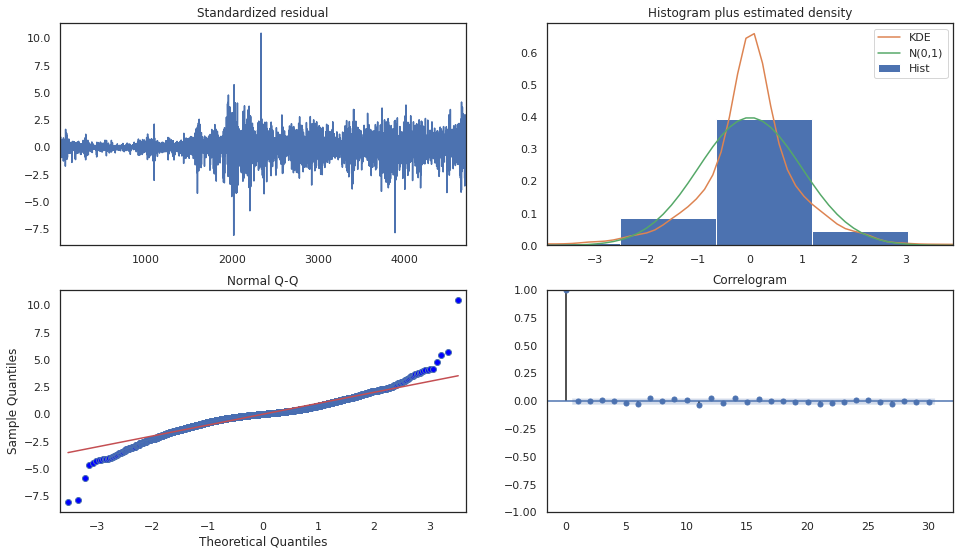

In [104]:
# Plot diagnostics of auto-regressor model
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)



Interpretation of above plots : 
To ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 
In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

Residuals are nearly normally distributed as KDE and N lines are closely followed but with different peaks.


The qq-plot shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1) with slight deviations at times. 

The residuals over time don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot which shows that the time series residuals have low correlation with lagged versions of itself.


Those observations can be used conclude that our model produces a good fit that help us to understand our time series data and forecast future values.

In [116]:
# Taking care so that our dataset dont duplicate on features of date
nifty = nifty.drop(['Date'], axis = 1)
nifty = nifty.reset_index()

## Auto-ARIMA Model

In [105]:
pip install pmdarima


### Without Exogenous features

In [106]:
# ARIMA without exogenous features

nifty_train = nifty[nifty.Date < "2019"]
nifty_valid = nifty[nifty.Date >= "2019"]

training = nifty_train['Close']
validation = nifty_valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=580)
forecast = pd.DataFrame(forecast,index = nifty_valid.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=11.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=55289.711, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=53961.208, Time=2.90 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.87 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=55252.116, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=53507.800, Time=5.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=20.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=53543.837, Time=4.43 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=53508.830, Time=8.37 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=53509.100, Time=16.83 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=53507.132, Time=6.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=53960.822, Time=2.61 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=23.01 sec
 ARIMA(0,1,1)(1,1,1)[12]       

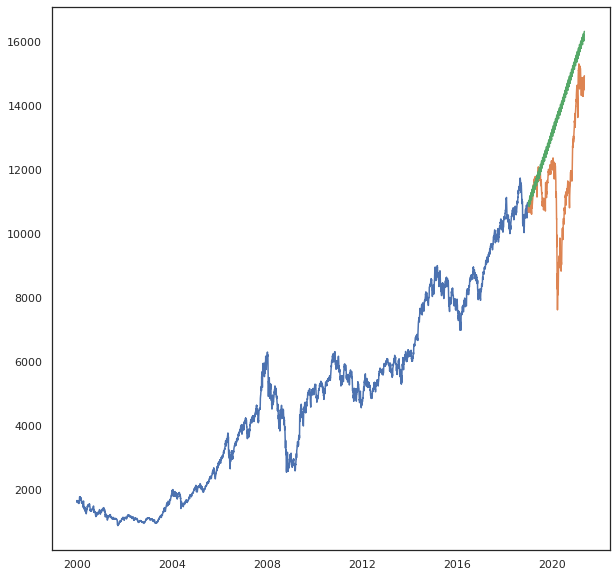

In [107]:
plt.plot(nifty_train['Close'])
plt.plot(nifty_valid['Close'])
plt.plot(forecast['Prediction'])



In [109]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [110]:
# Calculating error for Auto-Arima without exgenous features
print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty.Close, forecast.Prediction),2),"%")

mean absoulte percentage error: 16.35 %


### Without Exogenous features

In [142]:
# Auto ARIMA with exgenous features
from pmdarima.arima import auto_arima
model = auto_arima(nifty_train.Close, exogenous= nifty_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(nifty_train.Close, exogenous=nifty_train[exogenous_features])
forecast = model.predict(n_periods=len(nifty_valid), exogenous=nifty_valid[exogenous_features])
nifty_valid["Forecast_ARIMAX"] = forecast


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56482.465, Time=5.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=55296.268, Time=5.92 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56477.965, Time=1.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=56478.026, Time=7.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55571.764, Time=29.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=56480.300, Time=25.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 74.595 seconds


In [143]:
# storing forecast ARIMAX in main dataset to plot
nifty['Forecast_ARIMAX'] = nifty_valid['Forecast_ARIMAX']

In [144]:
# Model summary of ARIMA 
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4721
Model:                        SARIMAX   Log Likelihood              -27626.134
Date:                Fri, 14 May 2021   AIC                          55296.268
Time:                        13:26:04   BIC                          55438.383
Sample:                             0   HQIC                         55346.223
                               - 4721                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.7940      9.520     -0.083      0.934     -19.453      17.865
High_lag1       0.0315      0.075      0.420      0.674      -0.115       0.178
High_lag3      -0.0008      0.168     -0.005      0.996      -0.330       0.328
High_lag7       0.1699      0.252      0.675      0.500      -0.324       0.663
High_lag30      0.1743      0.395      0.441      0.659      -0.601       0.949
Low_lag1       -0.0099      0.047     -0.212      0.832      -0.101       0.081
Low_lag3        0.0820      0.114      0.719      0.472      -0.141       0.306
Low_lag7        0.1587      0.189      0.838      0.402      -0.213       0.530
Low_lag30       0.1597      0.332      0.481      0.630      -0.491       0.811
Open_lag1      -0.0361      0.061     -0.595      0.552      -0.155       0.083
Open_lag3       0.0192      0.122      0.157      0.875      -0.220       0.258
Open_lag7      -0.0288      0.197     -0.146      0.884      -0.415       0.357
Open_lag30     -0.1483      0.370     -0.401      0.688      -0.873       0.576
Close_lag1      1.1313      0.062     18.240      0.000       1.010       1.253
Close_lag3     -0.2431      0.160     -1.515      0.130      -0.557       0.071
Close_lag7     -0.2673      0.262     -1.021      0.307      -0.780       0.246
Close_lag30    -0.1925      0.478     -0.403      0.687      -1.129       0.744
month           0.2241      3.960      0.057      0.955      -7.537       7.985
week            0.0143      0.911      0.016      0.987      -1.772       1.800
day             0.1120      0.234      0.479      0.632      -0.347       0.571
day_of_week     0.3101      1.151      0.269      0.788      -1.946       2.566
sigma2       7084.7482     18.539    382.160      0.000    7048.413    7121.083
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):         211904869.78
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                           -22.07
Prob(H) (two-sided):                  0.00   Kurtosis:                      1039.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

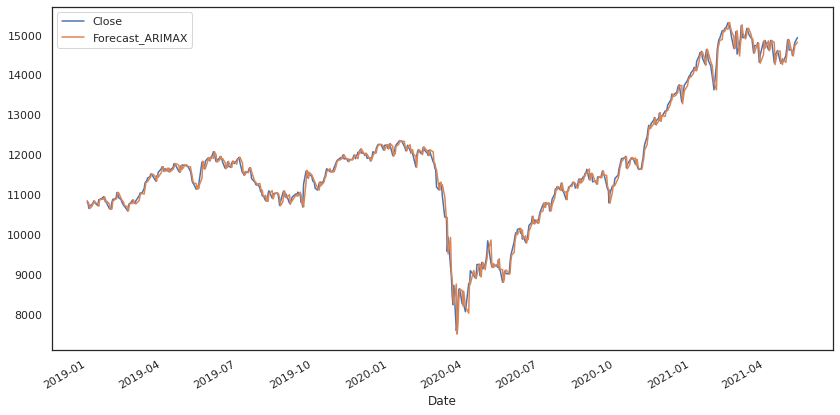

In [ ]:
# Plot of validation set with forecast
nifty_valid[["Close","Forecast_ARIMAX"]].plot(figsize=(14, 7))


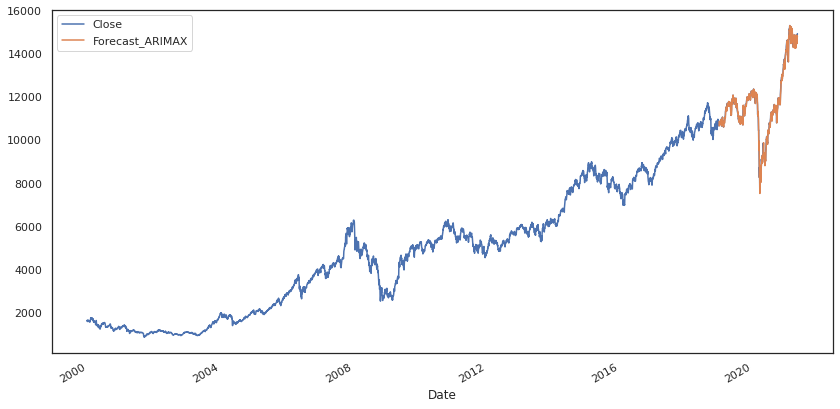

In [ ]:
# Plot of complete set with forecast
nifty[["Close","Forecast_ARIMAX"]].plot(figsize=(14, 7))


In [ ]:
# Error 
print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty.Close, nifty.Forecast_ARIMAX),2),"%")

mean absoulte percentage error: 0.95 %


## Facebook Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
!pip install prophet

In [184]:
df = nifty_train[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"})

In [186]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [187]:
future = m.make_future_dataframe(periods=1000)
#future.tail()

In [210]:
forecast = m.predict(future)
x = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [201]:
x.drop(['yhat_lower','yhat_upper'],axis =1,inplace = False)
df = df.append(x)
df = df.rename(columns = {'yhat':'Forecast_Prophet'} )

In [197]:
plot_components_plotly(m, forecast)


In [215]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [206]:
from fbprophet import Prophet
# Facebook Prophet
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(nifty_train[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"}))

forecast = model_fbp.predict(nifty_valid[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds"}))
nifty_valid["Forecast_Prophet"] = forecast.yhat.values


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


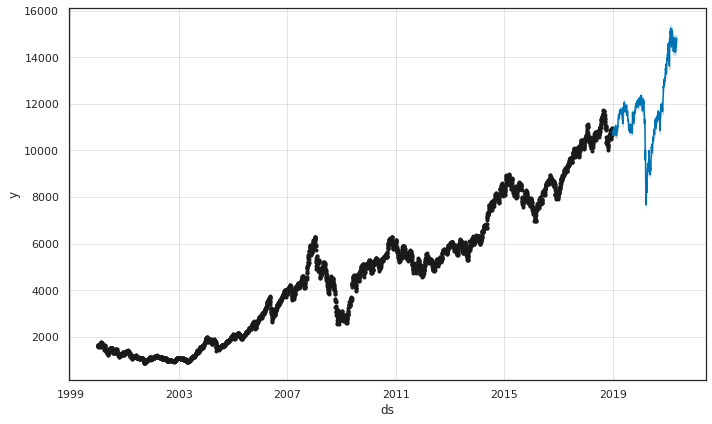

In [207]:
fig = model_fbp.plot(forecast)

The plots show that trends of decreasing from monday to saturday and january to december.

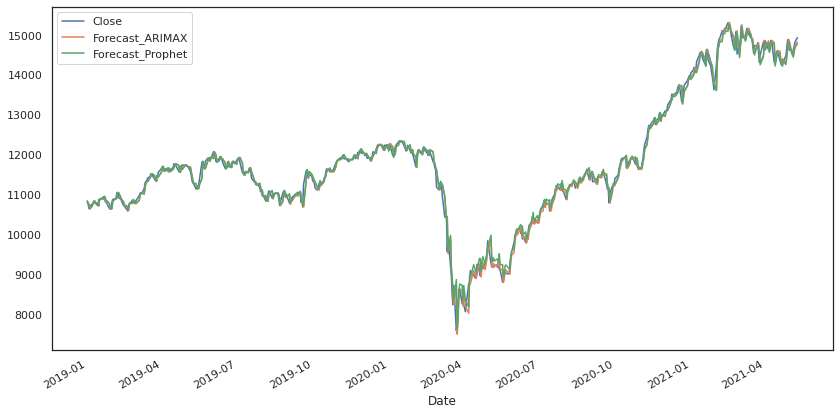

In [208]:


nifty_valid[["Close", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))


In [209]:
print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_Prophet),2),"%")

mean absoulte percentage error: 0.98 %


## Residual Analysis

In [219]:
residuals_Prophet=nifty_valid.Close-nifty_valid.Forecast_Prophet
residuals_ARIMAX=nifty_valid.Close-nifty_valid.Forecast_ARIMAX


In [223]:
dicky_fuller_test((residuals_Prophet))


ADF Statistic: -4.695022
p-value: 0.000086
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject the null hypothesis (H0), the data is stationary.


In [221]:
dicky_fuller_test((residuals_ARIMAX))


ADF Statistic: -7.963029
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject the null hypothesis (H0), the data is stationary.


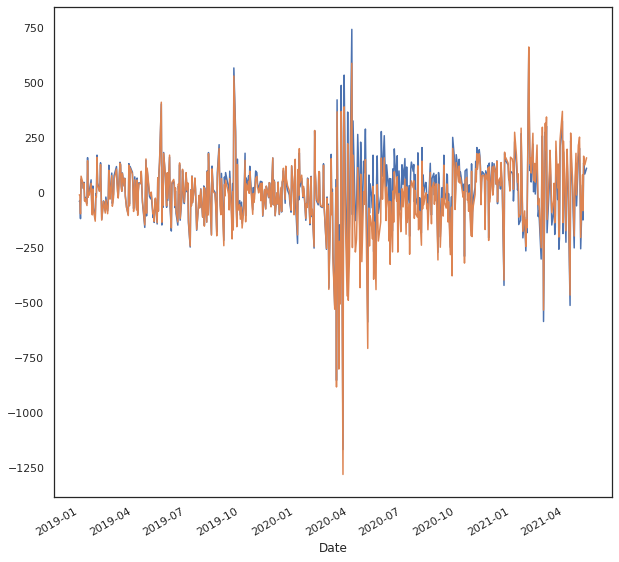

In [220]:
residuals_ARIMAX.plot()
residuals_Prophet.plot()


## Light XGB

In [ ]:
params = {"metric":"logloss"}

dtrain = lgb.Dataset(nifty_train[exogenous_features], label= nifty_train.Close.values)
dvalid = lgb.Dataset(nifty_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(nifty_valid[exogenous_features])
nifty_valid["Forecast_LightGBM"] = forecast


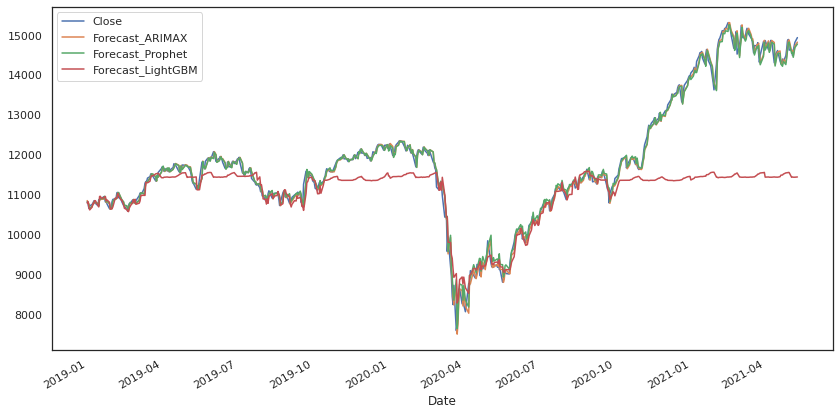

In [ ]:
nifty_valid[["Close", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))


In [ ]:
print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_LightGBM),2),"%")

mean absoulte percentage error: 5.98 %
